In [1]:
from sys import version_info
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from scipy.misc import imread, imshow
%matplotlib inline

In [2]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import BatchNormLayer, batch_norm
from lasagne.nonlinearities import softmax
import theano.tensor as T

try:
    import cPickle as pickle
except ImportError:
    import pickle

import lasagne.layers
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [3]:
! wget "https://s3.amazonaws.com/lasagne/recipes/pretrained/UNet_mass_road_segm_params.zip"

--2017-03-31 11:07:44--  https://s3.amazonaws.com/lasagne/recipes/pretrained/UNet_mass_road_segm_params.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.113.208
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.113.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11021111 (11M) [application/zip]
Saving to: ‘UNet_mass_road_segm_params.zip’

UNet_mass_road_segm 100%[===================>]  10.51M  5.88MB/s    in 1.8s    

2017-03-31 11:07:46 (5.88 MB/s) - ‘UNet_mass_road_segm_params.zip’ saved [11021111/11021111]



In [3]:
with open('UNet_params_pretrained.pkl', 'rb') as f:
    if version_info.major == 2:
        weights_nn = pickle.load(f)
    elif version_info.major == 3:
        weights_nn = pickle.load(f, encoding='latin1')

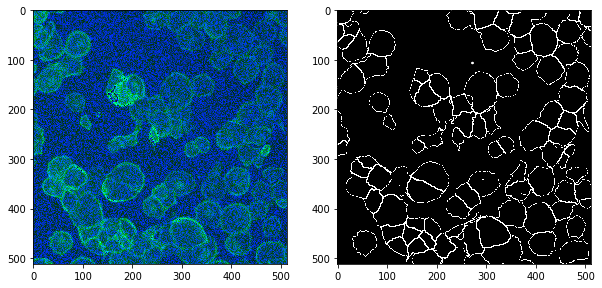

In [14]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [4]:
PATCH_SIZE = 64


def preprocess(patches):
    patches = patches.astype(np.float32)
    patches = patches / 255 - 0.5
    patches = patches.transpose(0,3,1,2)
    return patches


def read_data(dir_name, target=False):
    X = []
    for i, fname in enumerate(sorted(os.listdir(dir_name))):
        img = imread(dir_name + fname)
        X.append(img)
    X = np.stack(X)
    if target:
        return 1 * (X > 100)
    return X

def slice_on_patches(img, mask):
    X, masks = [], []
    for i in range(0, img.shape[0], PATCH_SIZE):
        for j in range(0, img.shape[0], PATCH_SIZE):  
            X.append(img[i:i + PATCH_SIZE, j:j + PATCH_SIZE, :])
            y = mask[i:i + PATCH_SIZE, j:j + PATCH_SIZE].ravel()
            y = np.concatenate(((y == 0).reshape(-1, 1), (y == 1).reshape(-1, 1)), axis=1).astype(int)
            masks.append(y)
    return np.array(X), np.array(masks)

def join_patches(img):
    result = np.zeros((0, img.shape[0]))
    for i in range(0, img.shape[0], PATCH_SIZE):
        part = np.zeros((PATCH_SIZE, 0))
        for j in range(0, img.shape[0], PATCH_SIZE): 
            mask = mask_predict_fun(img[i:i + PATCH_SIZE, j:j + PATCH_SIZE]\
                                     .reshape(1, 3, PATCH_SIZE, PATCH_SIZE))\
                                     .reshape(PATCH_SIZE, PATCH_SIZE, 2)[:, :, 1]
            part = np.concatenate((part, mask), axis=1)
        result = np.concatenate((result, part), axis=0)
    return result

In [5]:
X_train = read_data("BBBC018_v1_images-fixed/train/")
X_val = read_data("BBBC018_v1_images-fixed/val/")
y_train = read_data("BBBC018_v1_outlines/train/", True)
y_val = read_data("BBBC018_v1_outlines/val/", True)

In [46]:
X_train_patches, y_train_patches = [], []
for i in range(X_train.shape[0]):
    X, y = slice_on_patches(X_train[i], y_train[i])
    X_train_patches.append(X)
    y_train_patches.append(y)

In [47]:
X_train_patches = preprocess(np.concatenate(X_train_patches))
y_train_patches = np.concatenate(y_train_patches)

In [48]:
X_train_patches.shape, y_train_patches.shape

((2624, 3, 64, 64), (2624, 4096, 2))

In [49]:
X_val_patches, y_val_patches = [], []
for i in range(X_val.shape[0]):
    X, y = slice_on_patches(X_val[i], y_val[i])
    X_val_patches.append(X)
    y_val_patches.append(y)

In [50]:
X_val_patches = preprocess(np.concatenate(X_val_patches))
y_val_patches = np.concatenate(y_val_patches)

In [51]:
X_val_patches.shape, y_val_patches.shape

((448, 3, 64, 64), (448, 4096, 2))

# Unet

https://github.com/Lasagne/Recipes/blob/master/modelzoo/Unet.py

In [35]:
input_X = T.tensor4()
target_y = T.matrix(dtype='int64')

weights = T.vector("weights", dtype='float32') #class imbalance
learning_rate = T.scalar(name='learning_rate') #изменяющийся lr

In [11]:
from collections import OrderedDict
from lasagne.layers import (InputLayer, ConcatLayer, Pool2DLayer, ReshapeLayer, DimshuffleLayer, NonlinearityLayer,
                            DropoutLayer, Deconv2DLayer, batch_norm)
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except ImportError:
    from lasagne.layers import Conv2DLayer as ConvLayer
import lasagne
from lasagne.init import HeNormal


def build_UNet(n_input_channels=1, BATCH_SIZE=None, num_output_classes=2, pad='same', nonlinearity=lasagne.nonlinearities.elu, input_dim=(128, 128), base_n_filters=64, do_dropout=False):
    net = OrderedDict()
    net['input'] = InputLayer((BATCH_SIZE, n_input_channels, input_dim[0], input_dim[1]))

    net['contr_1_1'] = batch_norm(ConvLayer(net['input'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_1_2'] = batch_norm(ConvLayer(net['contr_1_1'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool1'] = Pool2DLayer(net['contr_1_2'], 2)

    net['contr_2_1'] = batch_norm(ConvLayer(net['pool1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_2_2'] = batch_norm(ConvLayer(net['contr_2_1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool2'] = Pool2DLayer(net['contr_2_2'], 2)

    net['contr_3_1'] = batch_norm(ConvLayer(net['pool2'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_3_2'] = batch_norm(ConvLayer(net['contr_3_1'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['pool3'] = Pool2DLayer(net['contr_3_2'], 2)

    net['contr_4_1'] = batch_norm(ConvLayer(net['pool3'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['contr_4_2'] = batch_norm(ConvLayer(net['contr_4_1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    l = net['pool4'] = Pool2DLayer(net['contr_4_2'], 2)
    # the paper does not really describe where and how dropout is added. Feel free to try more options
    if do_dropout:
        l = DropoutLayer(l, p=0.4)

    net['encode_1'] = batch_norm(ConvLayer(l, base_n_filters*16, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['encode_2'] = batch_norm(ConvLayer(net['encode_1'], base_n_filters*16, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale1'] = batch_norm(Deconv2DLayer(net['encode_2'], base_n_filters*16, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu"), name='upscale_1'))

    net['concat1'] = ConcatLayer([net['upscale1'], net['contr_4_2']], cropping=(None, None, "center", "center"))
    net['expand_1_1'] = batch_norm(ConvLayer(net['concat1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_1_2'] = batch_norm(ConvLayer(net['expand_1_1'], base_n_filters*8, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale2'] = batch_norm(Deconv2DLayer(net['expand_1_2'], base_n_filters*8, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu"), name='upscale_2'))

    net['concat2'] = ConcatLayer([net['upscale2'], net['contr_3_2']], cropping=(None, None, "center", "center"))
    net['expand_2_1'] = batch_norm(ConvLayer(net['concat2'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_2_2'] = batch_norm(ConvLayer(net['expand_2_1'], base_n_filters*4, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale3'] = batch_norm(Deconv2DLayer(net['expand_2_2'], base_n_filters*4, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu"), name='upscale_3'))

    net['concat3'] = ConcatLayer([net['upscale3'], net['contr_2_2']], cropping=(None, None, "center", "center"))
    net['expand_3_1'] = batch_norm(ConvLayer(net['concat3'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_3_2'] = batch_norm(ConvLayer(net['expand_3_1'], base_n_filters*2, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['upscale4'] = batch_norm(Deconv2DLayer(net['expand_3_2'], base_n_filters*2, 2, 2, crop="valid", nonlinearity=nonlinearity, W=HeNormal(gain="relu"), name='upscale_4'))

    net['concat4'] = ConcatLayer([net['upscale4'], net['contr_1_2']], cropping=(None, None, "center", "center"))
    net['expand_4_1'] = batch_norm(ConvLayer(net['concat4'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))
    net['expand_4_2'] = batch_norm(ConvLayer(net['expand_4_1'], base_n_filters, 3, nonlinearity=nonlinearity, pad=pad, W=HeNormal(gain="relu")))

    net['output_segmentation'] = ConvLayer(net['expand_4_2'], num_output_classes, 1, pad=pad, nonlinearity=None)
    net['dimshuffle'] = DimshuffleLayer(net['output_segmentation'], (1, 0, 2, 3))
    net['reshapeSeg'] = ReshapeLayer(net['dimshuffle'], (num_output_classes, -1))
    net['dimshuffle2'] = DimshuffleLayer(net['reshapeSeg'], (1, 0))
    net['output_flattened'] = NonlinearityLayer(net['dimshuffle2'], nonlinearity=lasagne.nonlinearities.softmax)
    net['output_shuffled'] = DimshuffleLayer(net['output_flattened'], (1, 0))
    net['output_shaped'] = ReshapeLayer(net['output_shuffled'], (num_output_classes, -1, input_dim[0]-8, input_dim[1]-8))
    net['output'] = DimshuffleLayer(net['output_shaped'], (1,2,3,0))
    return net


In [37]:
net = build_UNet(n_input_channels=3, BATCH_SIZE=None, num_output_classes=2, pad='same',
                nonlinearity=lasagne.nonlinearities.rectify, input_dim=(PATCH_SIZE, PATCH_SIZE),
                base_n_filters=16, do_dropout=False)

lasagne.layers.set_all_param_values(net['output'], weights_nn)

In [38]:
all_weights = lasagne.layers.get_all_params(net['output_flattened'], trainable=True)

In [39]:
y_predicted = lasagne.layers.get_output(net['output'], inputs=input_X)
mask_predicted = lasagne.layers.get_output(net['output_flattened'], inputs=input_X)

l2_loss = lasagne.regularization.regularize_network_params(net['output_flattened'], lasagne.regularization.l2)
# log_loss = lasagne.objectives.categorical_crossentropy(mask_predicted, target_y)
log_loss = lasagne.objectives.categorical_crossentropy(mask_predicted, target_y) * weights
loss = log_loss.mean() + l2_loss

accuracy = (lasagne.objectives.categorical_accuracy(mask_predicted, target_y)).mean()

updates_sgd = lasagne.updates.adam(loss, all_weights, learning_rate)

/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [40]:
# accuracy как-то неразумно. будем ориентироваться на intersection_over_union
pred = T.round(mask_predicted[:, 1]).astype("int64")
iou = T.sum(T.and_(target_y[:, 1], pred)) / T.sum(T.or_(target_y[:, 1], pred), dtype="float32")

/home/ubuntu/env/lib/python3.5/site-packages/theano/tensor/basic.py:2140: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [41]:
train_fun = theano.function([input_X, target_y, weights, learning_rate], [loss, accuracy, iou], \
                             updates=updates_sgd, allow_input_downcast=True)
accuracy_fun = theano.function([input_X, target_y, weights], [loss, accuracy, iou], allow_input_downcast=True)
predict_fun = theano.function([input_X], y_predicted)
mask_predict_fun = theano.function([input_X], mask_predicted)

In [42]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

### class imbalance

In [43]:
class_frequencies = np.array([np.sum(y_train[:, :, 1] == 0), np.sum(y_train[:, :, 1] == 1)], dtype="float32")
class_weights = (class_frequencies[[1,0]]) ** 0.25
class_weights = class_weights / np.sum(class_weights) * 2

In [ ]:
from IPython.display import clear_output
import time
t1 = time.time()
num_epochs = 10
learning_rate = 0.001
batch_size = 32

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    if num_epochs == 10:
        learning_rate *= 10
    train_err = 0
    train_acc = 0
    train_iou = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train_patches, y_train_patches.astype('int32'), batch_size):
        inputs, targets = batch
        targets = targets.reshape(-1, 2)
        train_err_batch, train_acc_batch, train_iou_batch = train_fun(inputs, targets, class_weights[targets[:, 1]],\
                                                                      learning_rate)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_iou += train_iou_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_err = 0
    val_batches = 0
    val_iou = 0
    for batch in iterate_minibatches(X_val_patches, y_val_patches, batch_size, False):
        inputs, targets = batch
        targets = targets.reshape(-1, 2)
        val_err_batch, val_acc_batch, val_iou_batch = accuracy_fun(inputs, targets, class_weights[targets[:, 1]])
        val_acc += val_acc_batch
        val_err += val_err_batch
        val_iou += val_iou_batch
        val_batches += 1


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  train loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  val loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  val accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    print("  train iou:\t\t{:.2f}".format(train_iou / train_batches))
    print("  val iou:\t\t{:.2f}".format(val_iou / val_batches))

Epoch 1 of 30 took 89.274s (Total: 89.274s)
  training loss (in-iteration):		0.118313
  validation loss (in-iteration):		0.113550
  train accuracy:		95.21 %
  validation accuracy:		95.28 %
  train iou:		0.23 
  validation iou:		0.26 
Epoch 2 of 30 took 89.381s (Total: 178.656s)
  training loss (in-iteration):		0.113010
  validation loss (in-iteration):		0.097866
  train accuracy:		95.31 %
  validation accuracy:		95.50 %
  train iou:		0.24 
  validation iou:		0.26 
Epoch 3 of 30 took 89.297s (Total: 267.954s)
  training loss (in-iteration):		0.110187
  validation loss (in-iteration):		0.102267
  train accuracy:		95.30 %
  validation accuracy:		95.56 %
  train iou:		0.25 
  validation iou:		0.28 
Epoch 4 of 30 took 89.335s (Total: 357.290s)
  training loss (in-iteration):		0.108383
  validation loss (in-iteration):		0.105739
  train accuracy:		95.29 %
  validation accuracy:		95.34 %
  train iou:		0.25 
  validation iou:		0.25 
Epoch 5 of 30 took 89.336s (Total: 446.627s)
  training loss 

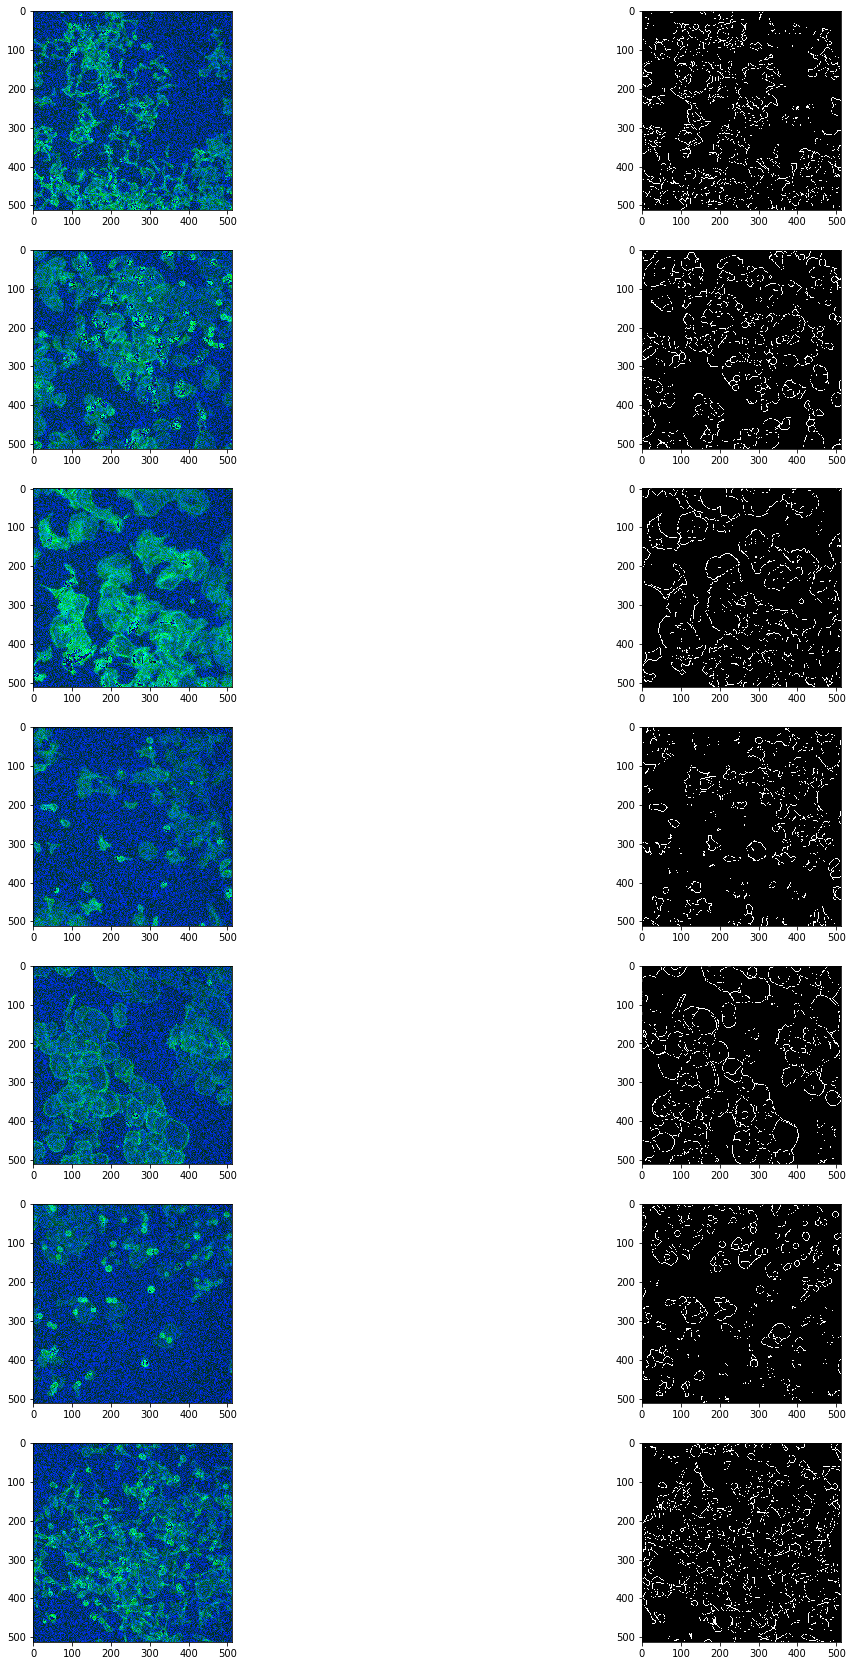

In [28]:
plt.figure(figsize=(20, 30))
for i, img in enumerate(X_test):
    plt.subplot(7, 2, i * 2 + 1)
    plt.imshow(img.transpose(1, 2, 0))
    mask = join_patches(img.transpose(1, 2, 0), PATCH_SIZE)
    plt.subplot(7, 2, i * 2 + 2)
    plt.imshow((mask > 0.5).astype("float32"), 'gray')

При выполнении данной домашки активо юзался данный ноутбук
https://github.com/Lasagne/Recipes/blob/master/examples/UNet/massachusetts_road_segm.py

Вообще, если еще какой-нибудь MRF применить, то еще круче будет

Какие были эксперименты: регуляризаторы, изменяющийся lr, разные веса для классов, разные patch_size. Самой печальной была попытка использовать 'UNet_params_pretrained.pkl', но на них как-то вообще странно работало, либо я неправильно что-то делала